In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from keras.models import Sequential
from keras.layers import SimpleRNN
from numpy import array
import datetime as dt
from datetime import date,timedelta

## 1. Đọc dữ liệu

In [2]:
data1 = pd.read_csv('/kaggle/input/train-dataset/stock_prices.csv')
data2 = pd.read_csv('/kaggle/input/train-dataset/secondary_stock_prices.csv')
data = pd.concat([data1, data2], axis=0)
data.head(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


## 2. Tìm hiểu dữ liệu

> Thông tin các cột có trong bảng dữ liệu:<br>
**RowId:** ID duy nhất của bản ghi giá, sự kết hợp của Ngày và Mã chứng khoán.<br>
**Date:** Ngày giao dịch.<br>
**SecuritiesCode:** Mã chứng khoán địa phương.<br>
**Open:** Giá đầu tiên được giao dịch trong một ngày.<br>
**High:** Giá giao dịch cao nhất trong một ngày.<br>
**Low:** Giá giao dịch thấp nhất trong một ngày.<br>
**Close:** Giá cuối cùng được giao dịch trong một ngày.<br>
**Volume:** Số lượng cổ phiếu được giao dịch trong một ngày.<br>
**AdjustmentFactor:** Được sử dụng để tính toán giá/volume lý thuyết khi có sự chia cổ phiếu hoặc gộp ngược cổ phiếu (KHÔNG bao gồm cổ tức/phát hành cổ phiếu).<br>
**ExpectedDividend:** Giá trị cổ tức dự kiến cho ngày ex-right. Giá trị này được ghi lại 2 ngày làm việc trước ngày ex-dividend.<br>
**SupervisionFlag:** Cờ của chứng khoán được giám sát và chứng khoán sẽ bị hủy niêm yết, để biết thêm thông tin, vui lòng xem tại đây.<br>
**Target:** Tỷ lệ biến đổi của giá đóng cửa điều chỉnh giữa t+2 và t+1, trong đó t+0 là ngày giao dịch.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4717106 entries, 0 to 2384574
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 436.4+ MB


In [4]:
# Chuyển đổi cột Date sang kiểu dữ liệu DateTime
data['Date'] = pd.to_datetime(data['Date'])

In [5]:
# tìm hiểu dữ liệu
data.describe()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,4717106,4.717106e+06,4.617747e+06,4.617747e+06,4.617747e+06,4.617747e+06,4.717106e+06,4.717106e+06,37323.000000,4.716150e+06
mean,2019-06-30 09:05:58.564763904,5.557378e+03,5.899877e+03,5.955175e+03,5.842733e+03,5.898684e+03,4.616900e+05,1.000806e+00,93.425679,3.716426e-04
min,2017-01-04 00:00:00,1.301000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e-01,0.000000,-9.213483e-01
25%,2018-04-06 00:00:00,3.390000e+03,7.130000e+02,7.210000e+02,7.030000e+02,7.120000e+02,6.000000e+03,1.000000e+00,0.000000,-9.761388e-03
50%,2019-07-05 00:00:00,5.821000e+03,1.395000e+03,1.411000e+03,1.376000e+03,1.394000e+03,3.660000e+04,1.000000e+00,10.000000,0.000000e+00
75%,2020-09-28 00:00:00,7.705000e+03,2.586000e+03,2.615000e+03,2.552000e+03,2.584000e+03,1.794000e+05,1.000000e+00,25.000000,9.362461e-03
max,2021-12-03 00:00:00,2.593500e+04,9.060000e+05,9.140000e+05,9.050000e+05,9.070000e+05,6.436540e+08,2.000000e+02,15180.000000,6.065637e+00
std,NaN,2.528957e+03,3.552297e+04,3.581772e+04,3.522635e+04,3.552194e+04,3.353114e+06,1.235042e-01,693.842678,2.626136e-02


In [6]:
data.isnull().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                  99359
High                  99359
Low                   99359
Close                 99359
Volume                    0
AdjustmentFactor          0
ExpectedDividend    4679783
SupervisionFlag           0
Target                  956
dtype: int64

In [7]:
# Xử lý dữ liệu
df = data.drop(['RowId'], axis = 1)
 
# Thay thế các giá trị NaN trong ExpectedDividend bằng giá trị 0
df['ExpectedDividend'].fillna(0, inplace=True)
# Điền vào các giá trị còn trống trong các cột Open High Low Close Target
df['Open'].fillna(df['Open'].mean(), inplace=True)
df['High'].fillna(df['High'].mean(), inplace=True)
df['Low'].fillna(df['Low'].mean(), inplace=True)
df['Close'].fillna(df['Close'].mean(), inplace=True)
df['Target'].fillna(df['Target'].mean(), inplace=True) 

df.head(5)



,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.0,False,0.000730
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,0.0,False,0.006154
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,0.0,False,0.011053
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,0.0,False,0.003026


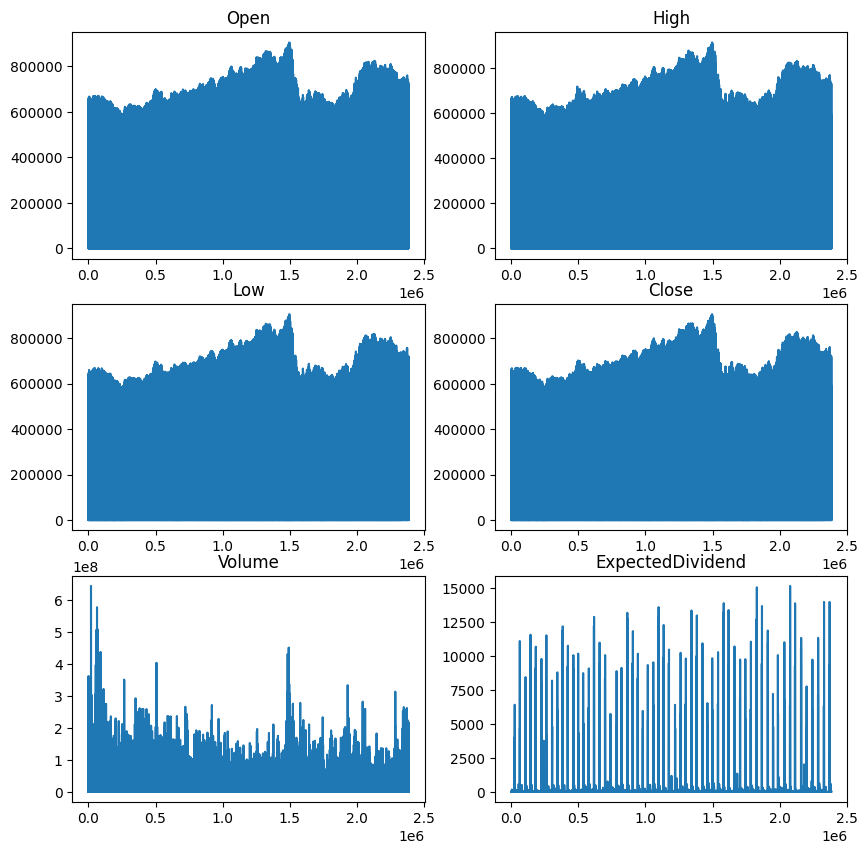

In [8]:
# Trực quan hóa các đặc trưng open high low close volumn AdjustmentFactor ExpectedDividend  target
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.plot(df['Open'])
plt.title('Open')
plt.subplot(3,2,2)
plt.plot(df['High'])
plt.title('High')
plt.subplot(3,2,3)
plt.plot(df['Low'])
plt.title('Low')
plt.subplot(3,2,4)
plt.plot(df['Close'])
plt.title('Close')
plt.subplot(3,2,5)
plt.plot(df['Volume'])
plt.title('Volume')
plt.subplot(3,2,6)
plt.plot(df['ExpectedDividend'])
plt.title('ExpectedDividend')
plt.show()

<Figure size 3000x3000 with 0 Axes>

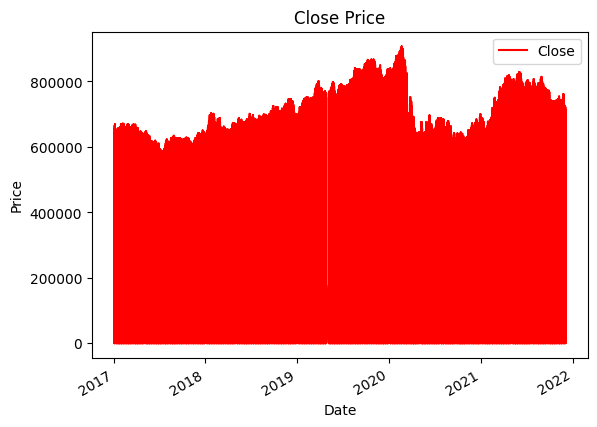

In [9]:
# Trực quan kết quả giá đóng cổ phiếu của các ngày trong tập dữ liệu bằng biểu đồ đường
plt.figure(figsize=(30,30))
df.plot('Date','Close',color="red")
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


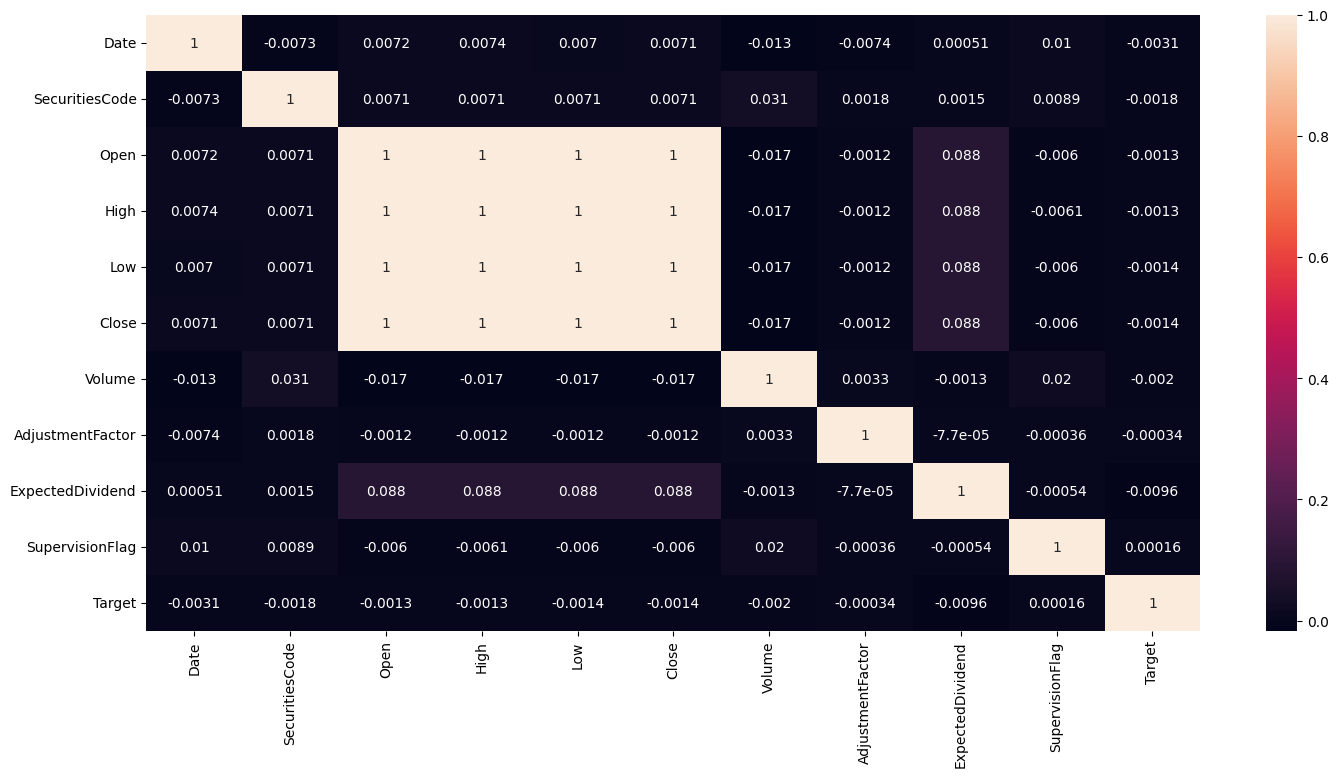

In [10]:
import seaborn as sns
plt.figure(1 , figsize = (17 , 8))
cor = sns.heatmap(df.corr(), annot = True)

***Dựa vào biểu đồ heatmap ta nhận thấy các giá trị Open High Low Close có quan hệ mật thiết với nhau, nên ta sẽ sử dụng các đặc trưng này để xây dựng mô hình dự đoán giá cổ phiếu***

## 3. Chuẩn bị dữ liệu cho mô hình

In [11]:
df1 = df.copy()
df1 = df1.drop(columns=['SupervisionFlag','ExpectedDividend','AdjustmentFactor','Target'], axis=1)
df1.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800


**Vì thị trường JPX đóng cửa vào Thứ Bảy, Chủ nhật, ngày lễ quốc gia và vào những ngày được nêu bên dưới. Nên ta cần loại bỏ các ngày này và không cần dự đoán**

In [12]:
# create lists of Japanese Stock Market Holidays (non-weekend)
Japan_Holidays_2017 = ['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-09', '2017-02-11', '2017-03-20', '2017-04-29', '2017-05-03', '2017-05-04', '2017-05-05', '2017-07-17', '2017-08-11', '2017-09-18', '2017-09-23', '2017-10-09', '2017-11-03', '2017-11-23', '2017-12-31']
Japan_Holidays_2018 = ['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-08', '2018-02-11', '2018-02-12', '2018-03-21', '2018-04-29', '2018-04-30', '2018-05-03', '2018-05-04', '2018-05-05', '2018-07-16', '2018-08-11', '2018-09-17', '2018-09-23', '2018-09-24', '2018-11-03', '2018-11-23', '2018-12-31']
Japan_Holidays_2019 = ['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-14', '2019-02-11', '2019-03-21', '2019-04-29', '2019-05-03', '2019-05-06', '2019-07-15', '2019-08-12', '2019-09-16', '2019-09-23', '2019-10-14', '2019-11-04', '2019-12-31']
Japan_Holidays_2020 = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-13', '2020-02-11', '2020-02-24', '2020-03-20', '2020-04-29', '2020-05-04', '2020-05-05', '2020-05-06', '2020-07-23', '2020-07-24', '2020-08-10', '2020-09-21', '2020-09-22', '2020-11-03', '2020-11-23', '2020-12-31']
Japan_Holidays_2021 = ['2021-01-01', '2021-01-11', '2021-02-11', '2021-02-23', '2021-04-29', '2021-05-03', '2021-05-04', '2021-05-05', '2021-07-22', '2021-07-23', '2021-08-09', '2021-09-20', '2021-09-23', '2021-11-03', '2021-11-23', '2021-12-31']

# Concatenate lists
Japan_Holidays = Japan_Holidays_2017 + Japan_Holidays_2018 + Japan_Holidays_2019 + Japan_Holidays_2020 + Japan_Holidays_2021

# Convert to actual dates
Japan_Holidays_2017to2021 = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in Japan_Holidays]

In [13]:
# create a unique list of all the securities and order them
securities = df1.SecuritiesCode.unique()
securities.sort()
securities=securities.tolist()
del securities[100:]

print(len(securities))
print(securities[-1])

100
1477


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)


## 3. Xây dựng mô hình dự đoán với mô hình LSTM

In [15]:
# Create the predictions for all stocks
stock_predictions={}
start_prices={}
for stock in securities:
    one_stock_df=df1.loc[df1['SecuritiesCode']==stock]
    one_stock_df.reset_index(drop=True, inplace=True)
    #adjust input parameters for stocks that have less than 300 trading days
    if len(one_stock_df) < 233:
        input_parameter=70
    elif len(one_stock_df) < 300:
        input_parameter=80
    else:
        input_parameter=100
    # get the last stock price
    start_price = one_stock_df["Close"].iloc[-1]
    start_prices[stock]=start_price
    
    # only use the Close column for predicting
    one_stock_close_df=one_stock_df.reset_index()['Close']
    
    # remove previous model data
    tf.keras.backend.clear_session()
    
    ### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
    scaler=MinMaxScaler(feature_range=(0,1))
    one_stock_scaler=scaler.fit_transform(np.array(one_stock_close_df).reshape(-1,1))
    
    # splitting the dataset into train and test splits
    training_size=int(len(one_stock_scaler)*0.65)
    test_size=len(one_stock_scaler)-training_size
    train_data,test_data=one_stock_scaler[0:training_size,:],one_stock_scaler[training_size:len(one_stock_scaler),:1]
    
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    time_step = input_parameter
    X_train, y_train=create_dataset(train_data, time_step)
    X_test, y_test=create_dataset(test_data, time_step)
    
    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
    X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
        
    # Create the Stacked LSTM model
    model_LSTM=Sequential()
    model_LSTM.add(LSTM(int(input_parameter/2),return_sequences=True,input_shape=(input_parameter,1),activation='relu'))
    #model_LSTM.add(Dropout(0.3))
    model_LSTM.add(LSTM(int(input_parameter/2),return_sequences=True,activation='relu'))
    #model_LSTM.add(Dropout(0.3))
    model_LSTM.add(LSTM(int(input_parameter/2),activation='relu'))
    model_LSTM.add(Dropout(0.3))
    model_LSTM.add(Dense(1))
    model_LSTM.compile(loss='mean_squared_error',optimizer='adam')

    # fit to the model
    history = model_LSTM.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64,verbose=1)
    
    # prediction and check performance metrics
    train_predict=model_LSTM.predict(X_train)
    test_predict=model_LSTM.predict(X_test)
    
    # transform back to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    
    # setup to predict future stock prices
    input_start=len(test_data)-input_parameter
    x_input=test_data[input_start:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    
    # prediction for the number of days 
    lst_output=[]
    n_steps=input_parameter
    i=0
    while(i<56):
        if(len(temp_input)>input_parameter):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model_LSTM.predict(x_input,verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model_LSTM.predict(x_input,verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
   
    # add the stock id and predictions to a list
    predicted_scaler=scaler.inverse_transform(lst_output)
    predicted_values=predicted_scaler.tolist()
    stock_predictions[stock]=predicted_values
    print(f"Securities code: {stock} just finished.")    
    print("\n")


Epoch 1/15
11/11 [==============================] - 5s 171ms/step - loss: 0.0536 - val_loss: 0.0051
Epoch 2/15
11/11 [==============================] - 1s 125ms/step - loss: 0.0134 - val_loss: 0.0054
Epoch 3/15
11/11 [==============================] - 1s 133ms/step - loss: 0.0086 - val_loss: 0.0032
Epoch 4/15
11/11 [==============================] - 1s 131ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 5/15
11/11 [==============================] - 1s 133ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 6/15
11/11 [==============================] - 1s 130ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 7/15
11/11 [==============================] - 1s 132ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 8/15
11/11 [==============================] - 1s 131ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 9/15
11/11 [==============================] - 1s 126ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/15
11/11 [==============================] - 1s 132ms/step - loss: 0.0034 - val_loss: 0.0034

In [16]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Lưu mô hình
model_LSTM.save('stock_prediction_model_LSTM.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4. XÂY DỰNG MÔ HÌNH RNN 

In [18]:
# Create the predictions for all stocks
stock_predictions_rnn={}
start_prices_rnn={}

for stock in securities:
    one_stock_df_rnn=df1.loc[df1['SecuritiesCode']==stock]
    one_stock_df_rnn.reset_index(drop=True, inplace=True)
    
    #adjust input parameters for stocks that have less than 300 trading days
    if len(one_stock_df_rnn) < 233:
        input_parameter=70
    elif len(one_stock_df_rnn) < 300:
        input_parameter=80
    else:
        input_parameter=100
         
    # get the last stock price
    start_price_rnn = one_stock_df_rnn["Close"].iloc[-1]
    start_prices_rnn[stock]=start_price_rnn
    
    # only use the Close column for predicting
    one_stock_close_df_rnn=one_stock_df_rnn.reset_index()['Close']
    
    # remove previous model data
    tf.keras.backend.clear_session()
    
    ### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
    scaler=MinMaxScaler(feature_range=(0,1))
    one_stock_scaler_rnn=scaler.fit_transform(np.array(one_stock_close_df_rnn).reshape(-1,1))
    
    # splitting the dataset into train and test splits
    training_size=int(len(one_stock_scaler_rnn)*0.65)
    test_size=len(one_stock_scaler_rnn)-training_size
    train_data_rnn,test_data_rnn=one_stock_scaler_rnn[0:training_size,:],one_stock_scaler_rnn[training_size:len(one_stock_scaler_rnn),:1]
    
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    time_step = input_parameter
    X_train_rnn, y_train_rnn=create_dataset(train_data_rnn, time_step)
    X_test_rnn, y_test_rnn=create_dataset(test_data_rnn, time_step)
    
    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train_rnn=X_train_rnn.reshape(X_train_rnn.shape[0],X_train_rnn.shape[1],1)
    X_test_rnn=X_test_rnn.reshape(X_test_rnn.shape[0],X_test_rnn.shape[1],1)
        
    # Create the Stacked RNN model
    model_rnn=Sequential()
    model_rnn.add(SimpleRNN(int(input_parameter/2),return_sequences=True,activation = 'relu'))
    model_rnn.add(SimpleRNN(int(input_parameter/2),activation = 'relu'))
    model_rnn.add(Dropout(0.3))
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error',optimizer='rmsprop')

    # fit to the model
    model_rnn.fit(X_train_rnn,y_train_rnn,validation_data=(X_test_rnn,y_test_rnn),epochs=15,batch_size=64,verbose=1)
    
    # prediction and check performance metrics
    train_predict_rnn=model_rnn.predict(X_train_rnn)
    test_predict_rnn=model_rnn.predict(X_test_rnn)
    
    # transform back to original form
    train_predict_rnn=scaler.inverse_transform(train_predict_rnn)
    test_predict_rnn=scaler.inverse_transform(test_predict_rnn)
    
    # setup to predict future stock prices
    input_start=len(test_data_rnn)-input_parameter
    x_input=test_data_rnn[input_start:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    
    # prediction for the number of days 
    lst_output=[]
    n_steps=input_parameter
    i=0
    while(i<56):
        if(len(temp_input)>input_parameter):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model_rnn.predict(x_input,verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model_rnn.predict(x_input,verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
   
    # add the stock id and predictions to a list
    predicted_scaler_rnn=scaler.inverse_transform(lst_output)
    predicted_values_rnn=predicted_scaler_rnn.tolist()
    stock_predictions_rnn[stock]=predicted_values_rnn
    print(f"Securities code: {stock} just finished.")    
    print("\n")


Epoch 1/15
11/11 [==============================] - 3s 74ms/step - loss: 0.0135 - val_loss: 0.0038
Epoch 2/15
11/11 [==============================] - 0s 42ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 3/15
11/11 [==============================] - 0s 42ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 4/15
11/11 [==============================] - 0s 42ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 5/15
11/11 [==============================] - 0s 42ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 6/15
11/11 [==============================] - 0s 43ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/15
11/11 [==============================] - 0s 42ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/15
11/11 [==============================] - 0s 41ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 9/15
11/11 [==============================] - 0s 41ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 10/15
11/11 [==============================] - 1s 48ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 11/

In [19]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 7701 (30.08 KB)
Trainable params: 7701 (30.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model_rnn.save('stock_prediction_model_rnn.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4. Test mô hình LSTM và RNN trên một cổ phiếu cụ thể

In [21]:
one_stock_df=df1.loc[df1['SecuritiesCode']==6146]
one_stock_df.reset_index(drop=True, inplace=True)
one_stock_df.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume
0,2017-01-04,6146,14370.0,14550.0,14290.0,14470.0,274200
1,2017-01-05,6146,14470.0,14470.0,14110.0,14280.0,224900
2,2017-01-06,6146,13980.0,14170.0,13970.0,14090.0,194800
3,2017-01-10,6146,14280.0,14440.0,14210.0,14370.0,230100
4,2017-01-11,6146,14400.0,14470.0,14310.0,14340.0,145600


In [22]:
one_stock_close_df=one_stock_df.reset_index()['Close']
one_stock_close_df.head()

0    14470.0
1    14280.0
2    14090.0
3    14370.0
4    14340.0
Name: Close, dtype: float64

In [23]:
### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
one_stock_scaler=scaler.fit_transform(np.array(one_stock_close_df).reshape(-1,1))
one_stock_scaler

array([[0.2649449 ],
       [0.25907187],
       [0.25319885],
       ...,
       [0.8176272 ],
       [0.8222638 ],
       [0.82535486]])

In [24]:
# splitting the dataset into train and test splits
training_size=int(len(one_stock_scaler)*0.65)
test_size=len(one_stock_scaler)-training_size
train_data,test_data=one_stock_scaler[0:training_size,:],one_stock_scaler[training_size:len(one_stock_scaler),:1]

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train=create_dataset(train_data, time_step)
X_test, y_test=create_dataset(test_data, time_step)
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Epoch 1/15
11/11 [==============================] - 4s 185ms/step - loss: 0.0293 - val_loss: 0.0663
Epoch 2/15
11/11 [==============================] - 2s 143ms/step - loss: 0.0115 - val_loss: 0.0386
Epoch 3/15
11/11 [==============================] - 2s 145ms/step - loss: 0.0093 - val_loss: 0.0168
Epoch 4/15
11/11 [==============================] - 2s 142ms/step - loss: 0.0083 - val_loss: 0.0195
Epoch 5/15
11/11 [==============================] - 1s 138ms/step - loss: 0.0085 - val_loss: 0.0128
Epoch 6/15
11/11 [==============================] - 2s 147ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 7/15
11/11 [==============================] - 1s 135ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 8/15
11/11 [==============================] - 1s 136ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 9/15
11/11 [==============================] - 1s 135ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 10/15
11/11 [==============================] - 1s 133ms/step - loss: 0.0073 - val_loss: 0.0077

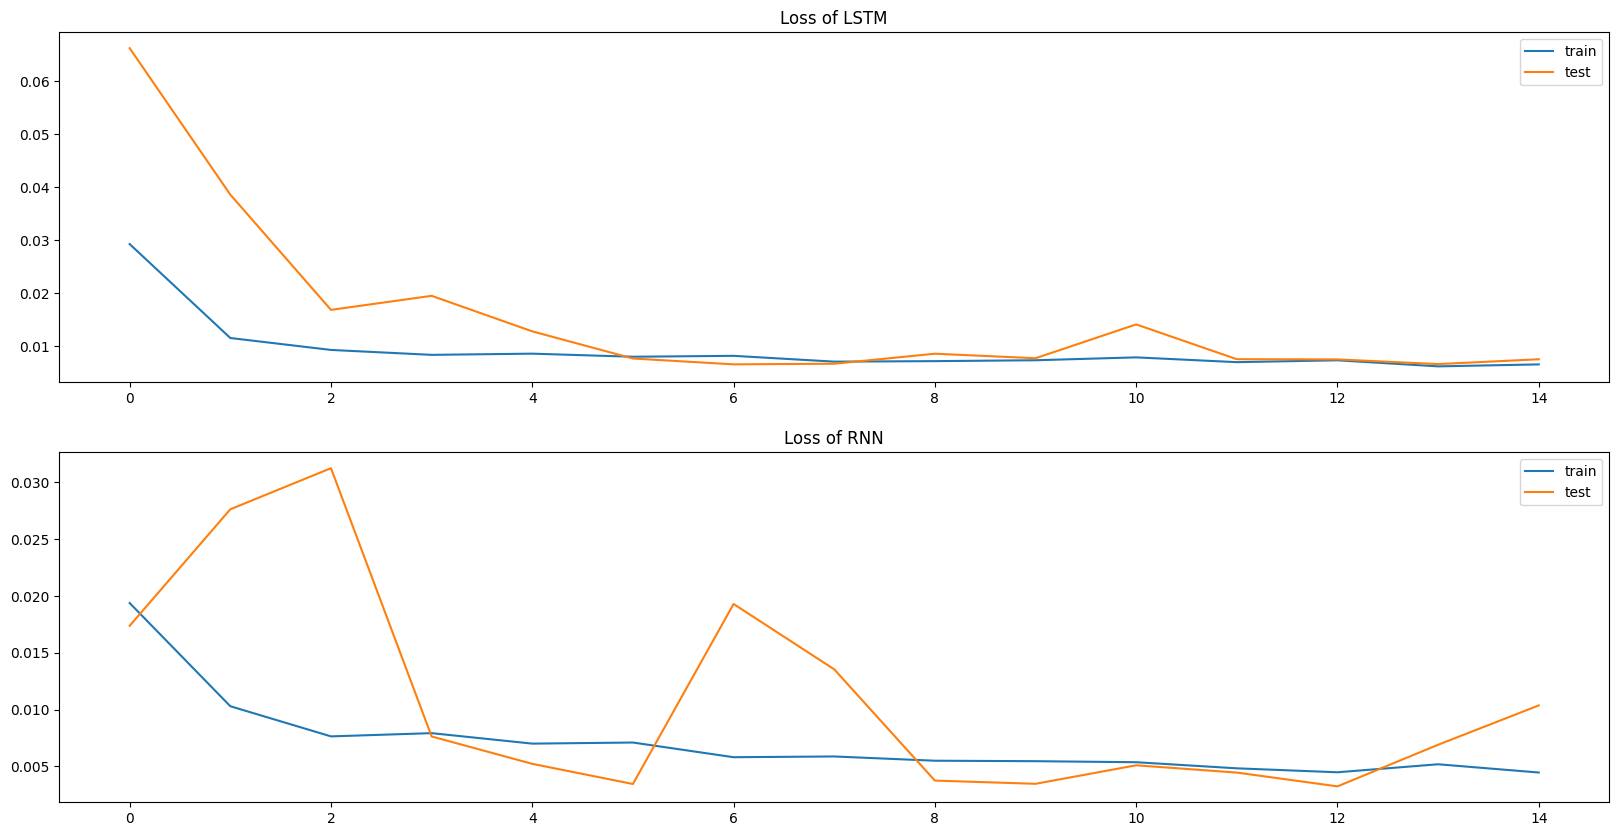

In [26]:
# Load mô hình 
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, recall_score,precision_score

model_1 = load_model('stock_prediction_model_LSTM.h5')
model_2 = load_model('stock_prediction_model_rnn.h5')

# Train model
test_output_lstm = model_1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64,verbose=1)
test_output_rnn = model_2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64,verbose=1)

# plot loss LSTM
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Loss of LSTM')
plt.plot(test_output_lstm.history['loss'], label='train')
plt.plot(test_output_lstm.history['val_loss'], label='test')
plt.legend()

# plot loss rnn
plt.subplot(212)
plt.title('Loss of RNN')
plt.plot(test_output_rnn.history['loss'], label='train')
plt.plot(test_output_rnn.history['val_loss'], label='test')
plt.legend()







In [27]:
y_pred_1 = model_1.predict(X_test)
y_pred_1 = np.argmax(y_pred_1, axis=1)
y_test_label_1 =  np.argmax(y_test.reshape(-1,1), axis=1)
# Tính precision tp / (tp + fp)
precision_lstm = precision_score(y_test_label_1, y_pred_1,average='micro')
print('Precision: %f' % precision_lstm)
# Tính recall: tp / (tp + fn)
recall_lstm = recall_score(y_test_label_1, y_pred_1,average='micro')
print('Recall: %f' % recall_lstm)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1_lstm = f1_score(y_test_label_1, y_pred_1, average='micro')
print('F1 score: %f' % f1_lstm)
# Tính loss
loss_lstm = model_1.evaluate(X_test, y_test)
print('loss: %f' % loss_lstm)

10/10 [==============================] - 1s 30ms/step
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
10/10 [==============================] - 1s 33ms/step - loss: 0.0075
loss: 0.007492


In [28]:
y_pred_2 = model_2.predict(X_test)
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_test_label_2 =  np.argmax(y_test.reshape(-1,1), axis=1)
# Tính precision tp / (tp + fp)
precision_rnn = precision_score(y_test_label_2, y_pred_2,average='micro')
print('Precision: %f' % precision_rnn)
# Tính recall: tp / (tp + fn)
recall_rnn = recall_score(y_test_label_2, y_pred_2,average='micro')
print('Recall: %f' % recall_rnn)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1_rnn = f1_score(y_test_label_2, y_pred_2, average='micro')
print('F1 score: %f' % f1_rnn)
# Tính loss
loss_rnn= model_2.evaluate(X_test, y_test)
print('loss: %f' % loss_rnn)

10/10 [==============================] - 0s 11ms/step
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
10/10 [==============================] - 0s 11ms/step - loss: 0.0104
loss: 0.010364


***Như kết quả trên, ta thấy được mô hình LSTM có kết quả tốt hơn so với mô hình RNN. Nên ta sẽ sử dụng kết quả dự đoán theo mô hình LSTM để tính toán và xếp hạng Rank cho từng loại cổ phiếu***

## 5. Tính toán và sắp xếp Rank các loại cổ phiếu

In [29]:
# calculate the daily percent change for all stocks for all forecast days and put into a series
stock_returns={}
forecast_days = 56
for i in range(len(stock_predictions)):
    percent_returns=[]
    first_return=0
    first_return=(stock_predictions[securities[i]][0][0]-start_prices[securities[i]])/start_prices[securities[i]]
    percent_returns.append(first_return)
    for j in range(forecast_days):
        if j < forecast_days-1:
            next_return= (stock_predictions[securities[i]][j+1][0]-stock_predictions[securities[i]][j][0])/stock_predictions[securities[i]][j][0]
            percent_returns.append(next_return)       
    stock_returns[securities[i]]=percent_returns

In [30]:
# create a rankings_df with stock return rankings
total_days=len(one_stock_df)
new_date=new_date=one_stock_df['Date'].iat[-1]
column_names =  ['Date', 'SecuritiesCode', 'Rank']
rankings_df = pd.DataFrame(columns=column_names)

for i in range(forecast_days):
    new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    while new_date.weekday()==5 or new_date.weekday()==6 or new_date.date() in Japan_Holidays_2017to2021:
        new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
        
    daily_percent_change=[]
    for j in range(len(stock_returns)):
        daily_percent_change.append(stock_returns[securities[j]][i])
    
    daily_percent_change_sr=pd.Series(daily_percent_change)
    daily_percent_change_sr.index=securities
    stock_rank = daily_percent_change_sr.rank(method='first',ascending=False)
    stock_rank=stock_rank.astype(int)    
    
    for j in range(len(stock_rank)):
        rankings_df.loc[j+i*len(stock_rank)] = [new_date.date(),securities[j], stock_rank[securities[j]]]

In [31]:
# check the daily percent change
stock_returns[securities[0]]

[-0.036685386995765235,
 0.0009439466144663062,
 -0.010101508842500625,
 -0.005726775745437363,
 -0.008398388515553995,
 -0.006492715067743735,
 -0.00833826677223393,
 -0.005711110339175318,
 -0.006385944914673305,
 -0.004183989134941791,
 -0.004427423717935282,
 -0.003329728289354129,
 -0.0037767357910232203,
 -0.0034754400470249037,
 -0.0032362009586439514,
 -0.0031438819447141666,
 -0.0031507968518842723,
 -0.0030832625025409826,
 -0.002970643776767749,
 -0.0031696295422157855,
 -0.003027711843464949,
 -0.0029459408881591315,
 -0.0024968257935575355,
 -0.002076736574192145,
 -0.0016722930868148184,
 -0.001237979055703703,
 -0.0008152812035351692,
 -0.00044765262363743216,
 -0.00027514520454752353,
 -0.00014552197670972627,
 -9.536731940086406e-05,
 -6.806370047684397e-05,
 -6.199265828826415e-05,
 -2.6973515613557714e-05,
 -2.2414484725928723e-05,
 -1.3108301102354286e-05,
 -1.0916802735059824e-05,
 -8.735614965644195e-06,
 -7.728126409313922e-06,
 -5.037863272545949e-06,
 -3.521328

In [32]:
rankings_df.head(20)

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,61
1,2021-12-06,1305,69
2,2021-12-06,1306,57
3,2021-12-06,1308,51
4,2021-12-06,1309,81
5,2021-12-06,1311,88
6,2021-12-06,1312,91
7,2021-12-06,1313,97
8,2021-12-06,1319,1
9,2021-12-06,1320,85


In [33]:
# write rankings_df to a csv file
filepath="test_stacked_lstm_rankings.csv"
rankings_df.to_csv(filepath,index=False)